# How does the natural organic matter data in the NMDC database compare across sample types?

In [1]:
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(readr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(jsonlite, warn.conflicts = FALSE)
library(ggExtra, warn.conflicts = FALSE)
options(warn = -1)

This notebook demonstrates how to use the existing NMDC-runtime API endpoints (as of August 2024) to explore the natural organic matter (NOM) data present in the NMDC database. It traverses the database schema backwards, first pulling all available natural organic matter results, and then identifying the corresponding source samples. The processed data is then evaluated for quality and compared by sample type. Note that retrieving the CSV results files can be time consuming.

## Define functions to interact with API

First, we will define R functions to interact with some of the available NMDC API endpoints. Further documentation of available API endpoints is available here: https://nmdc-documentation.readthedocs.io/en/latest/howto_guides/api_gui.html

### Define a general API call funtion to nmdc-runtime

This function provides a general-purpose way to make an API request to NMDC's runtime API. Note that this function will only return the first page of results. The function's input includes the name of the collection to access (e.g. `biosample_set`), the filter to be performed, the maximum page size, and a list of the fields to be retrieved. It returns the metadata as a dataframe.

In [2]:
get_first_page_results <- function(collection, filter, max_page_size, fields) {
  og_url <- paste0(
      'https://api.microbiomedata.org/nmdcschema/', 
      collection, '?&filter=', filter, '&max_page_size=', max_page_size, '&projection=', fields
      )
  
  response <- jsonlite::fromJSON(URLencode(og_url, repeated = TRUE))
  
  return(response)
}

### Define an nmdc-runtime API call function to include pagination

The `get_next_results` function uses the `get_first_page_results` function, defined above, to retrieve the rest of the results from a call with multiple pages. It takes the same inputs as the `get_first_page_results` function above: the name of the collection to be retrieved, the filter string, the maximum page size, and a list of the fields to be returned. This function returns the results as a single dataframe (can be nested). It uses the next_page_token key in each page of results to retrieve the following page.

In [3]:
get_next_results <- function(collection, filter_text, max_page_size, fields) {
  initial_data <- get_first_page_results(collection, filter_text, max_page_size, fields)
  results_df <- initial_data$resources
  
  if (!is.null(initial_data$next_page_token)) {
    next_page_token <- initial_data$next_page_token
    
    while (TRUE) {
      url <- paste0('https://api.microbiomedata.org/nmdcschema/', collection, '?&filter=', filter_text, '&max_page_size=', max_page_size, '&page_token=', next_page_token, '&projection=', fields)
      response <- jsonlite::fromJSON(URLencode(url, repeated = TRUE))

      results_df <- results_df %>% bind_rows(response$resources)
      next_page_token <- response$next_page_token
      
      if (is.null(next_page_token)) {
        break
      }
    }
  }
  
  return(results_df)
}

### Define an API request function to get object information for a given ID

This function constructs a different type of API request that takes a list of IDs and uses them to retrieve related data. In short, it searches in `collection` for records that have elements of `id_list` in their `match_id_field`, then returns all `fields` for the matching records.

Fields such as `has_input` or `has_output` are likely to be useful values for `match_id_field`, though other fields are also usable.

In [4]:
get_results_by_id <- function(collection, match_id_field, id_list, fields, max_id = 50) {
    # collection: the name of the collection to query
    # match_id_field: the field in the new collection to match to the id_list
    # id_list: a list of ids to filter on
    # fields: a list of fields to return
    # max_id: the maximum number of ids to include in a single query
    
    # If id_list is longer than max_id, split it into chunks of max_id
    if (length(id_list) > max_id) {
        id_list <- split(id_list, ceiling(seq_along(id_list)/max_id))
    } else {
        id_list <- list(id_list)
    }
    
    output <- list()
    for (i in 1:length(id_list)) {
        # Cast as a character vector and add double quotes around each ID
        mongo_id_string <- as.character(id_list[[i]]) %>%
            paste0('"', ., '"') %>%
            paste(collapse = ', ')
        
        # Create the filter string
        filter = paste0('{"', match_id_field, '": {"$in": [', mongo_id_string, ']}}')
        
        # Get the data
        output[[i]] = get_next_results(
            collection = collection,
            filter = filter,
            max_page_size = max_id*3, #assumes that there are no more than 3 records per query
            fields = fields
        )
    }
    output_df <- bind_rows(output)
}

### Define an API request function to identify the database collection for an ID

The functions above rely on knowing the MongoDB "collection" to search for relevant objects. But what if you don't know what the collection is called? This function takes an NMDC ID and returns the collection that the object is part of.

In [5]:
get_collection_by_id <- function(id) {
  
  # Create API endpoint URL
  url <- paste0("https://api.microbiomedata.org/nmdcschema/ids/", id, "/collection-name")

  # Retrieve the JSON result from the API endpoint URL
  response <- jsonlite::fromJSON(URLencode(url, repeated = TRUE))
  
  # Extract the collection name from the response
  return(response$collection_name)
}

## Query NMDC API

Now we will use the functions defined above to retrieve data from the NMDC database. In each step, we will 

### Get all data objects with NOM results

We will start by using the `get_next_results` function to retrieve all available processed data records containing NOM results. We are querying the `data_object_set` collection for objects that have the type `FT ICR-MS Analysis Results`. 

In [6]:
nom_dobj_df <- get_next_results(
    collection = "data_object_set", 
    filter_text = '{"data_object_type": {"$regex": "FT ICR-MS Analysis Results"}}', 
    max_page_size = 100, 
    fields = "id,name,url,was_generated_by,md5_checksum"
    )

head(nom_dobj_df, 3)

,id,name,md5_checksum,was_generated_by,url
,<chr>,<chr>,<chr>,<chr>,<chr>
1,nmdc:dobj-11-00dewm52,1000s_OSBS_FTMS_SPE_BTM_3_01Nov22_Mag_300SA_p025_184_1_7197.csv,2a532dca15798e470103ebd752a0937f,nmdc:wfnom-11-0mqv1c63.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000s_OSBS_FTMS_SPE_BTM_3_01Nov22_Mag_300SA_p025_184_1_7197.csv
2,nmdc:dobj-11-00wm3313,1000s_DELA_FTMS_SPE_TOP_2_29Oct22_Mag_300SA_p025_126_1_7076.csv,3ce562ac512457ea54bdda05a4f01ede,nmdc:wfnom-11-twkd5a03.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000s_DELA_FTMS_SPE_TOP_2_29Oct22_Mag_300SA_p025_126_1_7076.csv
3,nmdc:dobj-11-01kye625,1000S_CFS2_FTMS_SPE_TOP_2_run1_Fir_22Apr22_300SA_p01_12_1_3369.csv,38930c28eae561bc807bd01823f04167,nmdc:wfnom-11-ftaq2319.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000S_CFS2_FTMS_SPE_TOP_2_run1_Fir_22Apr22_300SA_p01_12_1_3369.csv


### Example of identifying a collection

We will use the `get_collection_by_id` function defined above to identify the name of the next collection to search in. Here, we have a list of IDs from the `data_object_set` collection, and we need to know the name of the collection containing the data analysis workflow information from the previous step.

In [7]:
# What collection holds records of the analysis that produced our processed data object?
get_collection_by_id(nom_dobj_df$was_generated_by[1])

[1] "nom_analysis_activity_set"

### Get all NOM analysis records

Now that we have a dataframe of processed data objects, we can use the data object IDs to identify the analysis processes that produced our results. In this case, we are looking in the `nom_analysis_activity_set` for any records whose output is listed as one of our data object IDs. These records represent the analysis workflows that take raw data from the instrument and produce processed data results.

In [8]:
nom_analysis_df <- get_results_by_id(
    collection = "nom_analysis_activity_set",
    match_id_field = "has_output",
    id_list = nom_dobj_df$id,
    fields = "id,has_input,has_output",
    max_id = 20
) %>%
  # Flatten results for viewing
  mutate(has_input = unlist(has_input),
         has_output = unlist(has_output))

head(nom_analysis_df, 3)

,id,has_input,has_output
,<chr>,<chr>,<chr>
1,nmdc:wfnom-11-snvsmz18.1,nmdc:dobj-11-esgqw196,nmdc:dobj-11-0bmapy68
2,nmdc:wfnom-11-ph9mfs20.1,nmdc:dobj-11-sj597780,nmdc:dobj-11-04v02904
3,nmdc:wfnom-11-jqhgtg36.1,nmdc:dobj-11-zzzrdh93,nmdc:dobj-11-09xct845


### Get all data objects containing raw NOM data

Continuing to work backwards towards the original biosample, we now use the analysis object IDs to identify the raw data objects that were analyzed. This step is also looking in the collection `data_object_set` that was used above. The difference is that this time, rather than filtering by type, we are looking for data objects that match our list of data object IDs that were input to the NOM analysis processes.

In [9]:
nom_raw_df <- get_results_by_id(
    collection = "data_object_set",
    match_id_field = "id",
    id_list = nom_analysis_df$has_input,
    fields = "id,was_generated_by,name,md5_checksum",
    max_id = 20
)

head(nom_raw_df, 3)

,id,name,md5_checksum,was_generated_by
,<chr>,<chr>,<chr>,<chr>
1,nmdc:dobj-11-2mk4qf09,1000s_DELA_FTMS_SPE_TOP_2_29Oct22_Mag_300SA_p025_126_1_7076.zip,67dd8ab4a5a2eae19d202846cb82a53b,nmdc:omprc-11-7xkvr465
2,nmdc:dobj-11-3hfzr472,1000s_OSBS_FTMS_SPE_BTM_3_01Nov22_Mag_300SA_p025_184_1_7197.zip,51bf125fdd6edfc73181f47e6b4eac2b,nmdc:omprc-11-2v9hsx10
3,nmdc:dobj-11-5c3mk733,WHONDRS_S19S_0054_ICR_3_214_Alder_Inf_27Sept19_IATp05_1_01_48835.zip,ff45b724d783b2ba36434f82303e2b67,nmdc:omprc-11-2yd98a53


### Get all records of omics analyses that produced raw NOM data

Using the list of raw data object IDs obtained above, we now search the `omics_processing_set` collection for records representing the mass spectrometry runs that produced our raw NOM data. Here we are looking for OmicsProcessing records whose `has_output` field matches the raw data object IDs.

In [10]:
nom_omprc_df <- get_results_by_id(
    collection = "omics_processing_set",
    match_id_field = "has_output",
    id_list = nom_raw_df$id,
    fields = "id,has_input,has_output",
    max_id = 20
) %>%
  # Flatten results for viewing
  mutate(has_input = unlist(has_input),
         has_output = unlist(has_output))

head(nom_omprc_df, 3)

,id,has_input,has_output
,<chr>,<chr>,<chr>
1,nmdc:omprc-11-7xkvr465,nmdc:bsm-11-yzgc1096,nmdc:dobj-11-2mk4qf09
2,nmdc:omprc-11-2v9hsx10,nmdc:bsm-11-sk8vv550,nmdc:dobj-11-3hfzr472
3,nmdc:omprc-11-2yd98a53,nmdc:bsm-11-jm05bk57,nmdc:dobj-11-5c3mk733


OmicsProcessing records represent the laboratory process resulting in omics data, such as sequencing or running a sample on a mass spectrometer. The input to OmicsProcessing records may be a Biosample, in the straightforward case where a sample was collected and analyzed. If a sample underwent additional processing first, such as pooling with other samples, there might be an additional ProcessedSample record connecting the Biosample to the OmicsProcessing record.

Here we will check all of our OmicsProcessing `has_input` results to see what records are upstream. This will help us avoid missing any connections to the Biosamples for the processed data results obtained in the first query.

In [11]:
# Confirm that all has_input fields are NMDC biosample IDs
nom_omprc_df %>%
  mutate(biosample_input = str_detect(has_input, "nmdc:bsm-")) %>%
  pull(biosample_input) %>%
  table()

.
TRUE 
2547 

All of the values for `has_input` have the format of an NMDC biosample identifier, so we only need to search in the Biosample collection.

### Get all records for biosamples that were processed for NOM analysis

Finally, we are able to use the inputs to the OmicsProcessing records obtained above to identify the original biosamples used. This will allow us to connect the sampling metadata to the processed NOM results. Here, we can add fields to the API query to retrieve more information about the original biosample. 

In this case, we are interested in the environments from which the samples were taken, so the `fields` argument includes the trio of environmental terms required for each NMDC biosample: `env_broad_scale`, `env_local_scale`, and `env_medium`. 

Passing an empty string to the `fields` argument of the API functions defined above returns all fields for the class being queried, which can be useful but slow. More information about the metadata fields for the `Biosample` class is available here: https://microbiomedata.github.io/nmdc-schema/Biosample/

In [12]:
nom_biosample_df <- get_results_by_id(
    collection = "biosample_set",
    match_id_field = "id",
    id_list = nom_omprc_df$has_input,
    fields = "id,name,part_of,env_broad_scale,env_local_scale,env_medium",
    #fields = "",
    max_id = 20
) %>%
  # Remove duplicate rows (some biosamples produce more than one processed sample)
  distinct() %>%
  # Flatten results for viewing
  mutate(part_of = as.character(part_of)) %>%
  unnest(starts_with("env"), names_sep = ".", keep_empty = TRUE) %>%
  unnest(starts_with("env"), names_sep = ".", keep_empty = TRUE)

head(nom_biosample_df, 3)

id,part_of,env_broad_scale.has_raw_value,env_broad_scale.term.id,env_broad_scale.term.name,env_local_scale.has_raw_value,env_local_scale.term.id,env_local_scale.term.name,env_medium.has_raw_value,env_medium.term.id,env_medium.term.name,name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-12esnc57,nmdc:sty-11-28tm5d36,urban biome [ENVO:01000249],ENVO:01000249,urban biome,woodland clearing [ENVO:00000444],ENVO:00000444,woodland clearing,forest soil [ENVO:00002261],ENVO:00002261,forest soil,1000 soils - WLUP_CoreB_TOP
nmdc:bsm-11-4gh52t60,nmdc:sty-11-5tgfr349,ENVO_01000253,ENVO:01000253,freshwater river biome,ENVO_00000022,ENVO:00000022,river,ENVO_00002042,ENVO:00002042,surface water,"Freshwater microbial communities from Red Butte Creek, Salt Lake City, Utah, USA - redbuttecreek_2019_sw_WHONDRS-S19S_0086"
nmdc:bsm-11-5w421v18,nmdc:sty-11-5tgfr349,ENVO_01000253,ENVO:01000253,freshwater river biome,ENVO_00000022,ENVO:00000022,river,ENVO_00002007,ENVO:00002007,sediment,"River sediment microbial communities from Colorado, USA - arikareeriver_2019_sed_WHONDRS-S19S_0023"


### Join all results dataframes

Now that we have covered each step that connects a biosample to its processed data output, we can join the dataframes by their common ID columns to produce one dataframe.

In [13]:
# Starting from the biosample dataframe...
nom_objects_joined <- nom_biosample_df %>%
  
  # Rename biosample columns with the prefix "bsm" for clarity
  rename_with(~ paste0("bsm.", .x)) %>%
  
  # Rename sample processing columns with the prefix "omprc"
  # Join records where the biosample ID is the input to the omics processing
  full_join(rename_with(nom_omprc_df, ~ paste0("omprc.", .x)), 
            by = join_by(bsm.id == omprc.has_input),
            keep = TRUE) %>%
  
  # Rename raw data object columns with the prefix "raw"
  # Join records where the raw data ID is the output of the omics processing
  full_join(rename_with(nom_raw_df, ~ paste0("raw.", .x)), 
            by = join_by(omprc.has_output == raw.id),
            keep = TRUE) %>%
  
  # Rename analysis columns with the prefix "analysis"
  # Join records where the raw data ID is the input of the analysis process
  full_join(rename_with(nom_analysis_df, ~ paste0("analysis.", .x)), 
            by = join_by(raw.id == analysis.has_input),
            keep = TRUE) %>%
  
  # Rename processed data object columns with the prefix "dobj"
  # Join records where the processed data ID is the output of the analysis process
  full_join(rename_with(nom_dobj_df, ~ paste0("dobj.", .x)), 
            by = join_by(analysis.has_output== dobj.id),
            keep = TRUE) %>%
  
  # Clean up: remove duplicate rows produced by joins
  distinct() %>%
  
  # Flatten list-columns
  # List-columns appear when a field included in the query is not flat (e.g. https://microbiomedata.github.io/nmdc-schema/env_medium/)
  unnest(where(is.data.frame), names_sep = ".", keep_empty = TRUE) %>%
  unnest(where(is.data.frame), names_sep = ".", keep_empty = TRUE) %>%
  mutate(across(where(is.list), as.character)) %>%
  
  # Remove duplicate processed data objects, if any are present
  filter(!duplicated(dobj.md5_checksum))


head(nom_objects_joined, 3)

bsm.id,bsm.part_of,bsm.env_broad_scale.has_raw_value,bsm.env_broad_scale.term.id,bsm.env_broad_scale.term.name,bsm.env_local_scale.has_raw_value,bsm.env_local_scale.term.id,bsm.env_local_scale.term.name,bsm.env_medium.has_raw_value,bsm.env_medium.term.id,⋯,raw.md5_checksum,raw.was_generated_by,analysis.id,analysis.has_input,analysis.has_output,dobj.id,dobj.name,dobj.md5_checksum,dobj.was_generated_by,dobj.url
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-12esnc57,nmdc:sty-11-28tm5d36,urban biome [ENVO:01000249],ENVO:01000249,urban biome,woodland clearing [ENVO:00000444],ENVO:00000444,woodland clearing,forest soil [ENVO:00002261],ENVO:00002261,⋯,d9667853b6ba2c184273c4e766a9019b,nmdc:omprc-11-s2590964,nmdc:wfnom-11-r8x4ew73.1,nmdc:dobj-11-vkheqz50,nmdc:dobj-11-07gsmc68,nmdc:dobj-11-07gsmc68,1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300SA_p01_115_1_3472.csv,9363e9de79c39013257ddb4d967006b2,nmdc:wfnom-11-r8x4ew73.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300SA_p01_115_1_3472.csv
nmdc:bsm-11-12esnc57,nmdc:sty-11-28tm5d36,urban biome [ENVO:01000249],ENVO:01000249,urban biome,woodland clearing [ENVO:00000444],ENVO:00000444,woodland clearing,forest soil [ENVO:00002261],ENVO:00002261,⋯,cdfca467c7ef39fdc5d72f91567038d8,nmdc:omprc-11-wj8myx84,nmdc:wfnom-11-xnhh0t17.1,nmdc:dobj-11-gdhnkg66,nmdc:dobj-11-0dyc2f79,nmdc:dobj-11-0dyc2f79,1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300SA_p01_1_1_3635.csv,9ace043441672422f7991411014ab9cb,nmdc:wfnom-11-xnhh0t17.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300SA_p01_1_1_3635.csv
nmdc:bsm-11-12esnc57,nmdc:sty-11-28tm5d36,urban biome [ENVO:01000249],ENVO:01000249,urban biome,woodland clearing [ENVO:00000444],ENVO:00000444,woodland clearing,forest soil [ENVO:00002261],ENVO:00002261,⋯,862f36ea5bb0f71fb6f64d45734d33e3,nmdc:omprc-11-6mbfsz04,nmdc:wfnom-11-edr3rn40.1,nmdc:dobj-11-qt6pmm77,nmdc:dobj-11-jj2r0a49,nmdc:dobj-11-jj2r0a49,1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300SA_p01_1_1_3514.csv,a502ec422a6f960972b759b143d8ad9c,nmdc:wfnom-11-edr3rn40.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300SA_p01_1_1_3514.csv


We will also check that all of the processed data objects were associated with a biosample, to make sure none are lost in the rest of the notebook.

In [14]:
# Are all processed data results from the first query present in the joined dataframe?
all(sort(unique(nom_dobj_df$id)) == sort(unique(nom_objects_joined$dobj.id)))

[1] TRUE

In [15]:
# How many processed data results are not associated with a biosample?
sum(is.na(nom_objects_joined$bsm.id))

[1] 0

## Label sample types

In this notebook we want to explore how natural organic matter varies across sample types. We can label the sample types using the environmental metadata terms included in the biosample query earlier.

Environmental metadata terms in the NMDC database are taken from controlled vocabularies, predominantly the Environment Ontology (ENVO). ENVO terms have a term name as well as an ID number (e.g. `peat soil [ENVO:00005774]`). Additional information about ENVO terms and their relationships can be found here: https://www.ebi.ac.uk/ols4/ontologies/envo

Here we use the `env_medium` field to identify whether our NOM samples came from soil, sediment, or water. `env_medium` actually contains a multilevel structure to represent the environmental term. `env_medium.has_raw_value` holds a string combining the term name and ID, `env_medium.term.id` contains the term ID number, and `env_medium.term.name` contains the term name, as shown below: 

In [16]:
nom_objects_joined$bsm.env_medium.has_raw_value[1]

[1] "forest soil [ENVO:00002261]"

In [17]:
nom_objects_joined$bsm.env_medium.term.id[1]

[1] "ENVO:00002261"

In [18]:
nom_objects_joined$bsm.env_medium.term.name[1]

[1] "forest soil "

Note that all of these fields should be filled out for all samples, however, due to differences in sample metadata submission by users, there may be gaps. Therefore we check multiple fields here to ensure that all samples are labeled.

In [19]:
nom_objects_joined_labeled <- nom_objects_joined %>%

  mutate(bsm.sample_type_manual = case_when(
    bsm.env_medium.term.id %in% c("ENVO:00001998", "ENVO:00002259", "ENVO:00002261", 
                                  "ENVO:00005750", "ENVO:00005760", "ENVO:00005761", 
                                  "ENVO:00005773", "ENVO:00005774", "ENVO:00005802", 
                                  "ENVO:01001616") ~ "soil",
    
    bsm.env_medium.term.id %in% c("ENVO:00002007") ~ "sediment",
    bsm.env_medium.term.id %in% c("ENVO:01000017") ~ "sand",
    bsm.env_medium.term.id %in% c("ENVO:00002042") ~ "water",
    
    str_detect(bsm.env_medium.term.name, "soil") ~ "soil",
    str_detect(bsm.env_medium.has_raw_value, "soil") ~ "soil",
    str_detect(bsm.env_medium.term.name, "water") ~ "water"
    ))

head(nom_objects_joined_labeled, 3)

bsm.id,bsm.part_of,bsm.env_broad_scale.has_raw_value,bsm.env_broad_scale.term.id,bsm.env_broad_scale.term.name,bsm.env_local_scale.has_raw_value,bsm.env_local_scale.term.id,bsm.env_local_scale.term.name,bsm.env_medium.has_raw_value,bsm.env_medium.term.id,⋯,raw.was_generated_by,analysis.id,analysis.has_input,analysis.has_output,dobj.id,dobj.name,dobj.md5_checksum,dobj.was_generated_by,dobj.url,bsm.sample_type_manual
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
nmdc:bsm-11-12esnc57,nmdc:sty-11-28tm5d36,urban biome [ENVO:01000249],ENVO:01000249,urban biome,woodland clearing [ENVO:00000444],ENVO:00000444,woodland clearing,forest soil [ENVO:00002261],ENVO:00002261,⋯,nmdc:omprc-11-s2590964,nmdc:wfnom-11-r8x4ew73.1,nmdc:dobj-11-vkheqz50,nmdc:dobj-11-07gsmc68,nmdc:dobj-11-07gsmc68,1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300SA_p01_115_1_3472.csv,9363e9de79c39013257ddb4d967006b2,nmdc:wfnom-11-r8x4ew73.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000S_WLUP_FTMS_SPE_TOP_1_run2_Fir_22Apr22_300SA_p01_115_1_3472.csv,soil
nmdc:bsm-11-12esnc57,nmdc:sty-11-28tm5d36,urban biome [ENVO:01000249],ENVO:01000249,urban biome,woodland clearing [ENVO:00000444],ENVO:00000444,woodland clearing,forest soil [ENVO:00002261],ENVO:00002261,⋯,nmdc:omprc-11-wj8myx84,nmdc:wfnom-11-xnhh0t17.1,nmdc:dobj-11-gdhnkg66,nmdc:dobj-11-0dyc2f79,nmdc:dobj-11-0dyc2f79,1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300SA_p01_1_1_3635.csv,9ace043441672422f7991411014ab9cb,nmdc:wfnom-11-xnhh0t17.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000S_WLUP_FTMS_SPE_TOP_3_run2_Fir_28Apr22_300SA_p01_1_1_3635.csv,soil
nmdc:bsm-11-12esnc57,nmdc:sty-11-28tm5d36,urban biome [ENVO:01000249],ENVO:01000249,urban biome,woodland clearing [ENVO:00000444],ENVO:00000444,woodland clearing,forest soil [ENVO:00002261],ENVO:00002261,⋯,nmdc:omprc-11-6mbfsz04,nmdc:wfnom-11-edr3rn40.1,nmdc:dobj-11-qt6pmm77,nmdc:dobj-11-jj2r0a49,nmdc:dobj-11-jj2r0a49,1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300SA_p01_1_1_3514.csv,a502ec422a6f960972b759b143d8ad9c,nmdc:wfnom-11-edr3rn40.1,https://nmdcdemo.emsl.pnnl.gov/nom/1000soils/results/1000S_WLUP_FTMS_SPE_TOP_3_run1_Fir_25Apr22_300SA_p01_1_1_3514.csv,soil


## Pull and process results files

The processed data objects pulled from the API above contain references to the results files, not the results themselves. We can use the `url` field of the DataObject class to retrieve the stored data. The NMDC natural organic matter workflow produces a results data table saved as a CSV at that url. The rows of the CSV correspond to m/z peaks in the mass spectra.

In [20]:
read_csv(nom_objects_joined_labeled$dobj.url[1],
         show_col_types = FALSE,
         name_repair = make.names) %>%
  head(3)

Index,m.z,Calibrated.m.z,Calculated.m.z,Peak.Height,Peak.Area,Resolving.Power,S.N,Ion.Charge,m.z.Error..ppm.,⋯,Ion.Type,Is.Isotopologue,Mono.Isotopic.Index,Molecular.Formula,C,H,O,N,S,X13C
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,129.0559,129.0557,129.0557,242988726,20417.22,2329664,1082.2314,-1,-0.002061316,⋯,de-protonated,0,NA,C6 H10 O3,6,10,3,NA,NA,NA
1,153.0195,153.0193,153.0193,66881533,7773.70,1473857,297.8792,-1,-0.010790850,⋯,de-protonated,0,NA,C7 H6 O4,7,6,4,NA,NA,NA
10,165.0195,165.0193,165.0193,83309137,11198.25,1366021,371.0450,-1,-0.018094142,⋯,de-protonated,0,NA,C8 H6 O4,8,6,4,NA,NA,NA


We will read the CSV files into R from each data object URL. 

Note that this step is the most time-consuming; it may take up to 40 minutes.

In [21]:
processed_data_csvs <- data.frame(data_object_url = nom_objects_joined_labeled$dobj.url) %>%
  filter(!is.na(data_object_url)) %>%
  mutate(csv_nested = lapply(data_object_url, read_csv, show_col_types = FALSE, name_repair = make.names))

The results table contains a lot of information. In this notebook, we are going to use the confidence score, molecular formula assignment, hydrogen/carbon ratio, and oxygen/carbon ratio columns.

In [22]:
colnames(processed_data_csvs$csv_nested[[1]])

[1] "Index"                   "m.z"                    
 [3] "Calibrated.m.z"          "Calculated.m.z"         
 [5] "Peak.Height"             "Peak.Area"              
 [7] "Resolving.Power"         "S.N"                    
 [9] "Ion.Charge"              "m.z.Error..ppm."        
[11] "m.z.Error.Score"         "Isotopologue.Similarity"
[13] "Confidence.Score"        "DBE"                    
[15] "H.C"                     "O.C"                    
[17] "Heteroatom.Class"        "Ion.Type"               
[19] "Is.Isotopologue"         "Mono.Isotopic.Index"    
[21] "Molecular.Formula"       "C"                      
[23] "H"                       "O"                      
[25] "N"                       "S"                      
[27] "X13C"

### Select best assignments

Rarely, a peak may match more than one molecular formula with high confidence. In these cases there would be more than one row for the peak, with duplicate indices and m/z values but different molecular formulae. In this case we will select the row with the highest confidence score to ensure that peaks are not duplicated within a results file.

In [23]:
processed_data_csvs <- processed_data_csvs %>%
  # For each results dataframe
  mutate(csv_nested = lapply(csv_nested, 
    function(x) {
      x %>%
        # Keep the row with the highest confidence score for every m/z value
        arrange(-Confidence.Score) %>%
        distinct(m.z, .keep_all = TRUE)
      }
    )
  )

### Quality metrics for processed data

We can extract the columns we need from the results table and calculate some quality metrics.

Percent Assigned Peaks: The percentage of peaks that were given a molecular formula assignment.

Confidence Score: The NMDC NOM workflow is based off of the CoreMS package, which outputs a confidence score for each molecular formula assignment. This allows us to potentially filter out less reliable assignments and move forward with higher confidence molecular formula identifications.

In [24]:
# Extract relevant columns and calculate some statistics for the processed data
processed_data_qc <- processed_data_csvs %>%
  
  mutate(unassigned_count  = vapply(csv_nested, function(x) sum(is.na(x$Molecular.Formula)), 
                                     FUN.VALUE = 1, USE.NAMES = FALSE),
         
         assigned_count    = vapply(csv_nested, function(x) sum(!is.na(x$Molecular.Formula)), 
                                     FUN.VALUE = 1, USE.NAMES = FALSE),
         
         assigned_perc     = assigned_count / (unassigned_count + assigned_count),
         
         confidence_scores = lapply(csv_nested, function(x) x$Confidence.Score))

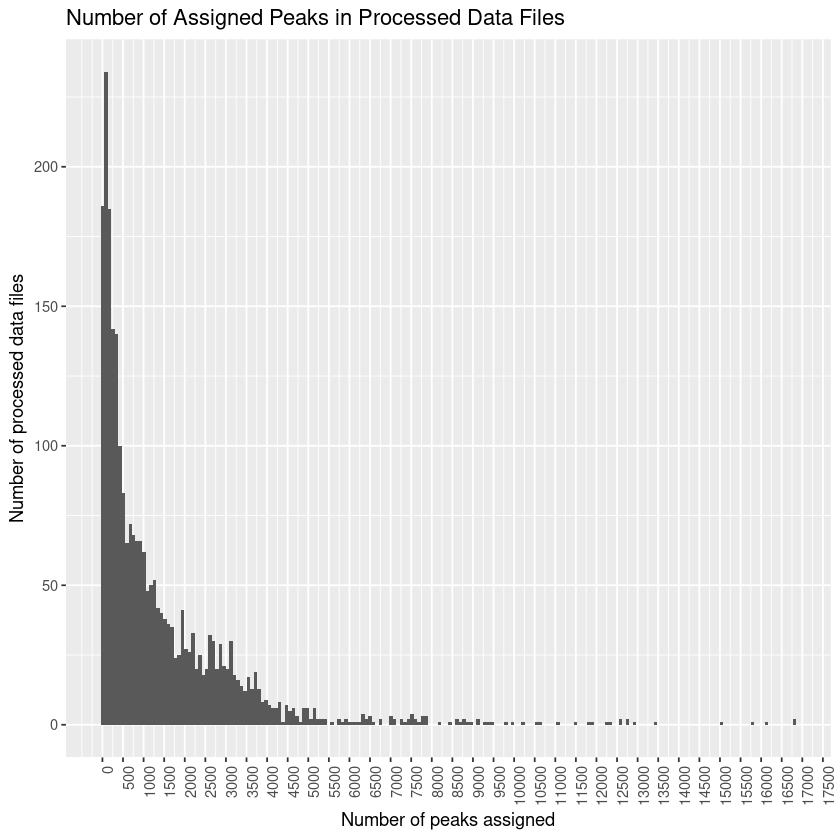

In [25]:
# How many data files have x number of peaks assigned?
ggplot(processed_data_qc) +
    geom_histogram(aes(x = assigned_count), bins = 200) +
    ggtitle("Number of Assigned Peaks in Processed Data Files") +
    xlab("Number of peaks assigned") +
    ylab("Number of processed data files") +
    scale_x_continuous(breaks = seq(0, 17500, by = 500)) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

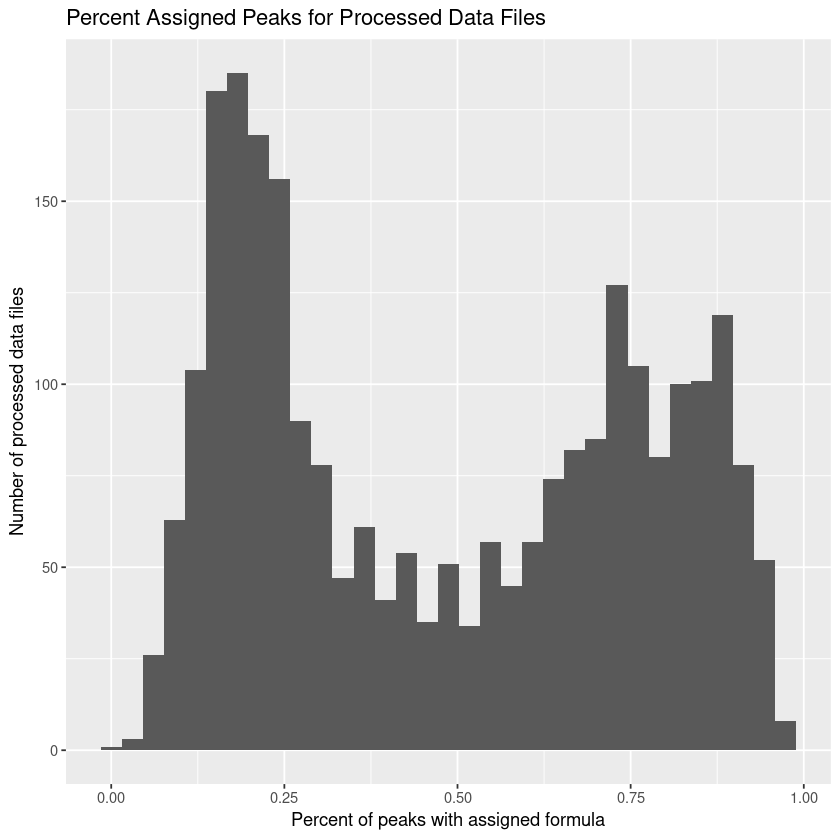

In [26]:
# How many data files have x % peaks assigned?
ggplot(processed_data_qc) +
  geom_histogram(aes(x = assigned_perc), bins = 33) +
  ggtitle("Percent Assigned Peaks for Processed Data Files") +
  xlab("Percent of peaks with assigned formula") +
  ylab("Number of processed data files")

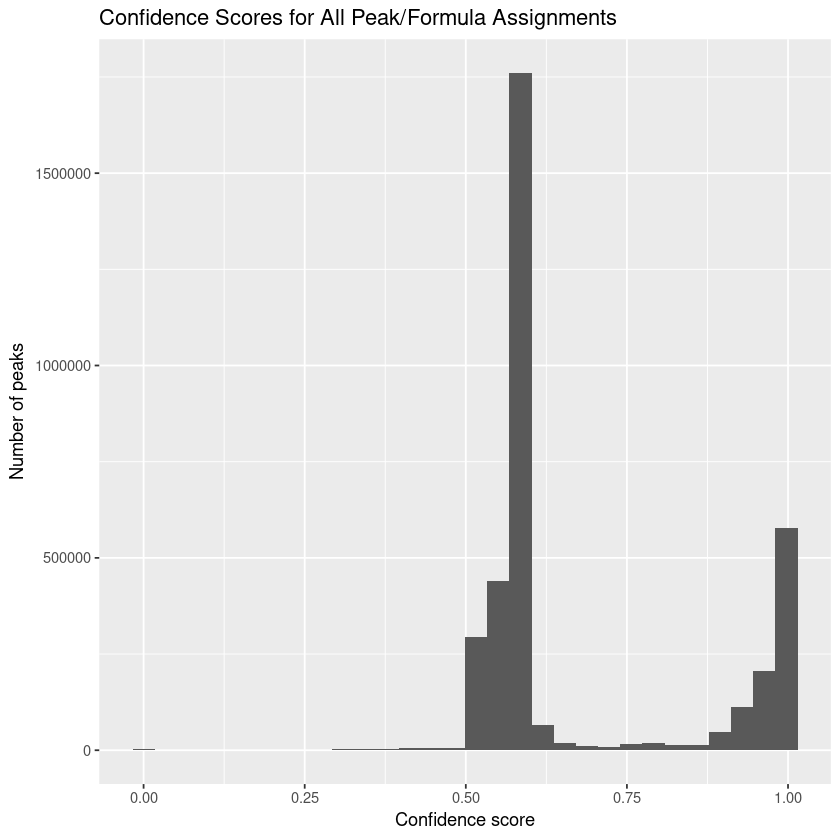

In [27]:
# How many peaks across all of our data were assigned x confidence score?
data.frame(All_Confidence_Scores = unlist(processed_data_qc$confidence_scores)) %>%
  ggplot() +
    geom_histogram(aes(x = All_Confidence_Scores), bins = 30) +
    ggtitle("Confidence Scores for All Peak/Formula Assignments") +
    xlab("Confidence score") +
    ylab("Number of peaks")

We can use the quality metrics to filter our data before moving forward with analysis.

First, we will remove results with less than 30% of their peaks assigned. Then we remove results with a low number of peaks assigned, since data with only a few peaks assigned will not be very informative. We apply a filter to each remaining data file to remove molecular formula assignments with confidence scores lower than 0.3.

In [28]:
processed_data_qc <- processed_data_qc %>%

  # Filter out samples with low percent assigned
  filter(assigned_perc > 0.3) %>%

  # Filter out samples with low NUMBER assigned
  filter(assigned_count > 200) %>%
  
  # Within data, filter out rows with low confidence score
  mutate(csv_nested = lapply(csv_nested, function(x) filter(x, Confidence.Score > 0.3))) %>%

  # Now that filtering is done, extract the rest of the data we want
  mutate(molecular_formulae = lapply(csv_nested, function(x) x$Molecular.Formula),
         HC                 = lapply(csv_nested, function(x) x$H.C),
         OC                 = lapply(csv_nested, function(x) x$O.C),
         # re-extract filtered confidence scores
         confidence_scores  = lapply(csv_nested, function(x) x$Confidence.Score)
  ) %>%
  
  # Remove nested dataset column for speed and memory
  select(-csv_nested)

## Visualizing natural organic matter by sample type

First we will see how many processed data objects from each sample type remain after quality filtering.

In [29]:
processed_data_qc %>%
  left_join(select(nom_objects_joined_labeled, dobj.url, bsm.sample_type_manual),
              by = join_by(data_object_url == dobj.url)) %>%
  pull(bsm.sample_type_manual) %>%
  table()

.
    sand sediment     soil    water 
      25       41     1101       32 

Most of the remaining data comes from soil samples. Sand has the fewest results remaining. We will use 25 of each type moving forward to visualize all sample types.

### Molecular formula heatmap

One way to compare samples is to investigate what molecular formulae they have in common. We will visualize this by creating a heatmap with a subset of samples of each type.

In [30]:
set.seed(10)

# Starting from the QC filtered data
samples_for_heatmap <- processed_data_qc %>%
  
  # Add biosample information
  left_join(select(nom_objects_joined_labeled, 
                   dobj.id, dobj.url, bsm.sample_type_manual), #, bsm.part_of, 
                   #bsm.lat_lon.latitude, bsm.lat_lon.longitude), 
            by = join_by(data_object_url == dobj.url)) %>%
  
  # Randomly sample 25 of each sample type (limited by only 25 sand samples)
  group_by(bsm.sample_type_manual) %>%
  slice_sample(n = 25) %>%
  ungroup()

We also filter down to molecular formulae that appear in at least 5 samples, both to make the plots less computationally demanding and to remove formulae that are less useful for comparing samples.

In [31]:
filtered_formulae <- samples_for_heatmap$molecular_formulae %>%
  # Get unique list of formulae from each results table
  lapply(unique) %>%
  unlist() %>%
  # Count occurrences of each formula
  table() %>%
  as.data.frame() %>%
  setNames(c("Formula", "Freq")) %>%
  # Remove stray empty strings and filter by frequency
  filter(Formula != "") %>%
  filter(Freq >= 5) %>%
  mutate(Formula = as.character(Formula)) %>%
  # Pull character vector of formulae appearing at least 5x in the random subsample
  pull(Formula)

One way to visualize similarities between samples is to investigate their shared formulae. We will construct a presence-absence heatmap showing which formulae are present in which results.

In [32]:
# Initialize presence absence matrix
# Rows are processed data (results data tables)
# Columns are molecular formulae

formula_presence <- matrix(, nrow = nrow(samples_for_heatmap), ncol = length(filtered_formulae))

for (i in 1:nrow(samples_for_heatmap)) {
  formula_presence[i,] <- ifelse(filtered_formulae %in% samples_for_heatmap$molecular_formulae[[i]], 
                       1, 0)
}

rownames(formula_presence) <- samples_for_heatmap$data_object_url
colnames(formula_presence) <- filtered_formulae

We will also construct a colored sidebar indicating which sample type each results row comes from. This will help visualize whether or not sample types cluster together.

In [33]:
# Set up color vector for side grouping column
sample_type_color_vec <- case_when(
  samples_for_heatmap$bsm.sample_type_manual == "soil" ~ "saddlebrown",
  samples_for_heatmap$bsm.sample_type_manual == "sediment" ~ "slategray",
  samples_for_heatmap$bsm.sample_type_manual == "water" ~ "deepskyblue",
  samples_for_heatmap$bsm.sample_type_manual == "sand" ~ "goldenrod")

The heatmap below shows molecular formulae that are present (orange) or absent (blue) in each processed data record. On the left, the dendrogram shows how the records clustered together based on similarity of molecular formulae. The column on the left shows sample type: blue is water, gray is sediment, yellow is sand, and brown is soil.

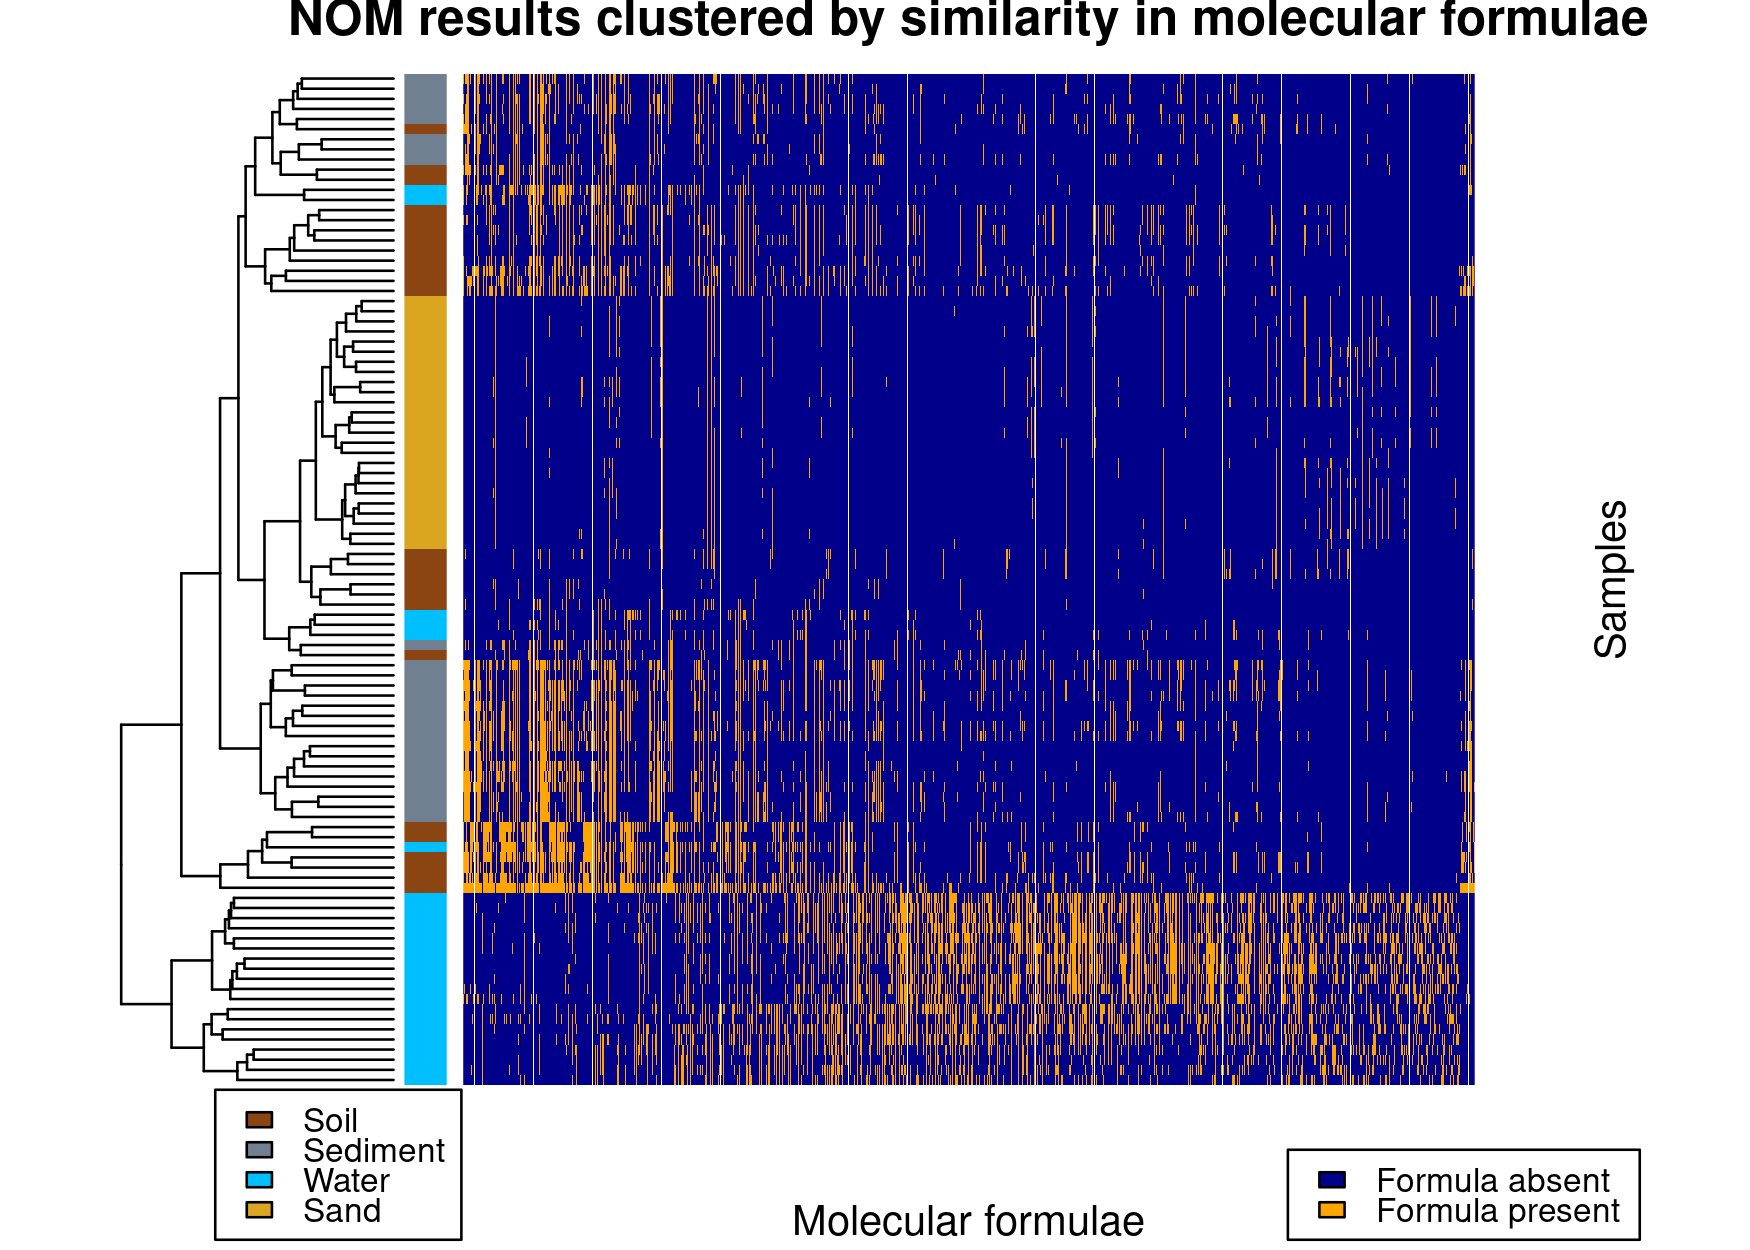

In [34]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 250)
par(xpd = TRUE)

heatmap(formula_presence, Colv = NA, RowSideColors = sample_type_color_vec, 
        labRow = FALSE, labCol = FALSE, scale = "none",
        main = "NOM results clustered by similarity in molecular formulae",
        xlab = "Molecular formulae",
        ylab = "Samples", 
        keep.dendro = FALSE, 
        col = c("darkblue", "orange"))

par(cex = 0.8)

legend(x = "bottomright", legend = c("Formula absent", "Formula present"), fill = c("darkblue", "orange"), inset = c(0, -0.2))

legend(x = "bottomleft", legend = c("Soil", "Sediment", "Water", "Sand"), fill = c("saddlebrown", "slategray", "deepskyblue", "goldenrod"), inset = c(0, -0.2))

### Van Krevelen plots

Van Krevelen plots are a common way to visualize samples of organic material. Each point on the scatterplot represents a molecular formula. The x-axis represents the hydrogen/carbon ratio of the molecule, and the y-axis represents the oxygen/carbon ratio. In this example, the data has been grouped by sample type rather than plotting all results individually.

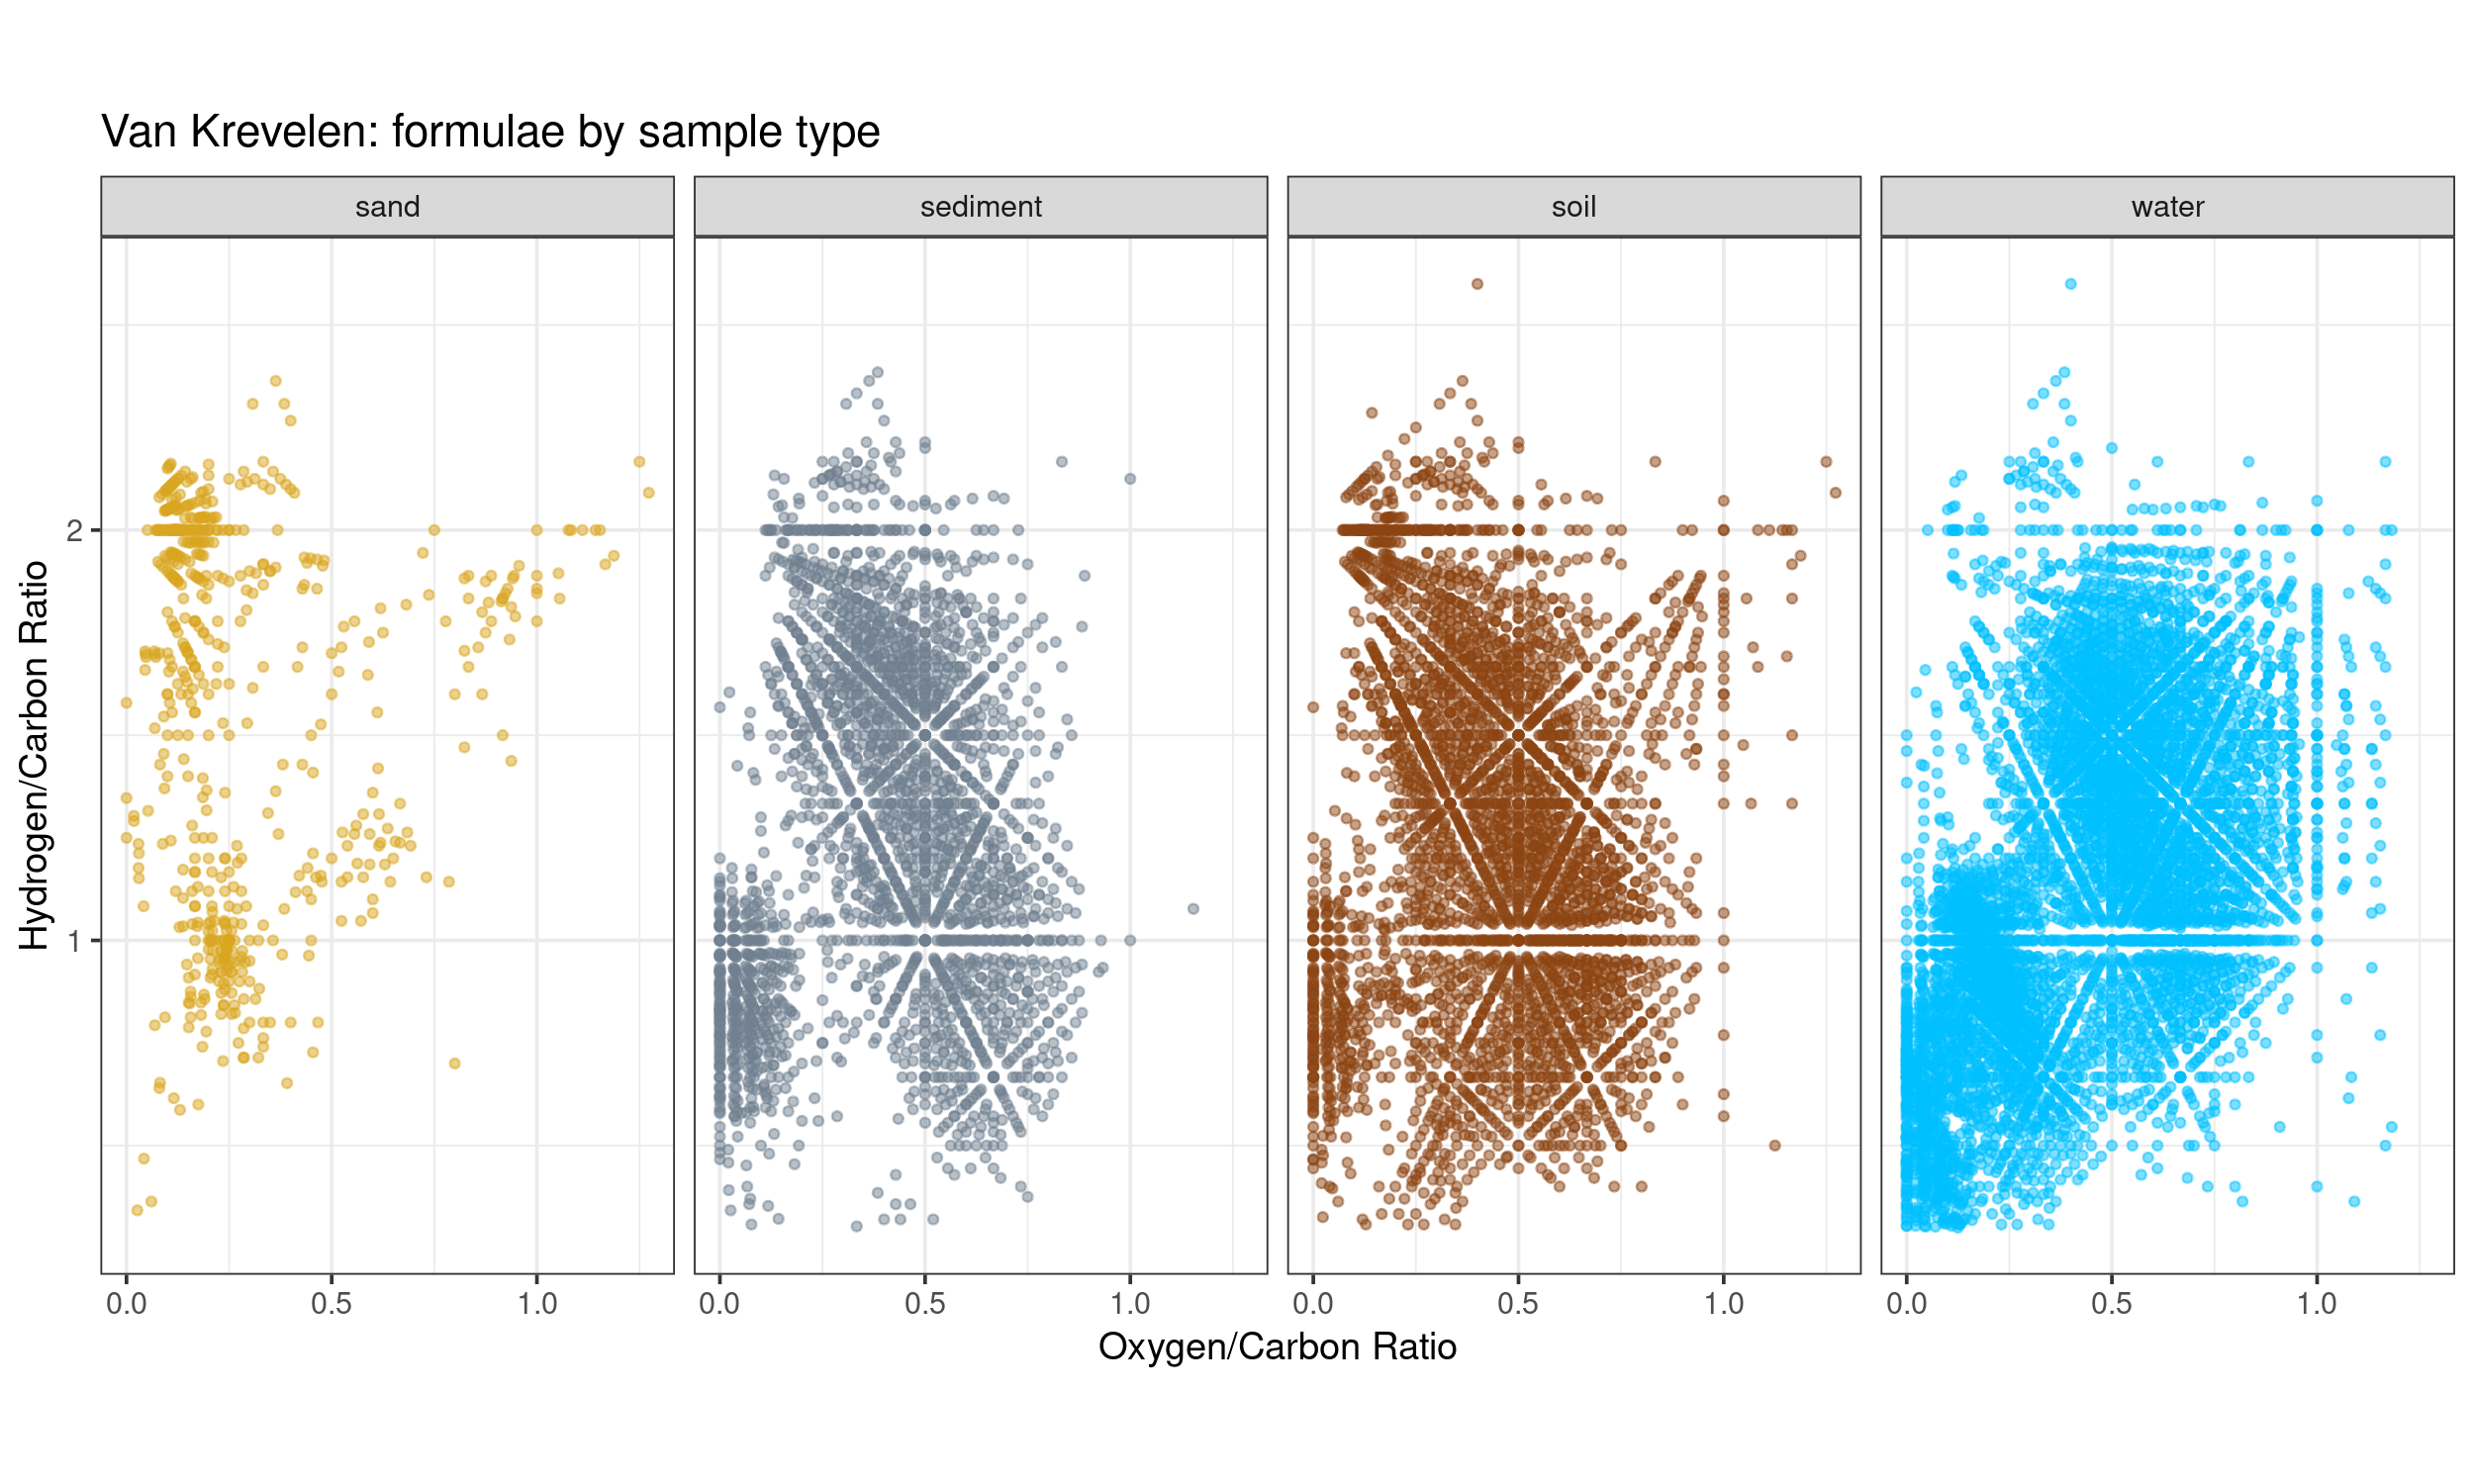

In [35]:
# Using the same subset of samples chosen for the heatmap
van_krevelen_data <- samples_for_heatmap %>%
  select(bsm.sample_type_manual, HC, OC, molecular_formulae) %>%
  unnest(cols = c(HC, OC, molecular_formulae)) %>% 
  # Filter down to formulae that appear at least 5 times (see above)
  filter(molecular_formulae %in% filtered_formulae) %>% 
  distinct() 

van_krevelen_separate_plot <- ggplot(van_krevelen_data, aes(x = OC, y = HC, color = bsm.sample_type_manual)) +
  geom_point(alpha = 0.5, size = 1) +
  facet_wrap(~bsm.sample_type_manual, nrow = 1) +
  theme_bw() +
  theme(legend.position = "none") +
  coord_fixed() +
  scale_color_manual("legend", values = c("soil" = "saddlebrown",
                                          "sediment" = "slategray",
                                          "water" = "deepskyblue",
                                          "sand" = "goldenrod")) +
  ggtitle("Van Krevelen: formulae by sample type") +
  xlab("Oxygen/Carbon Ratio") +
  ylab("Hydrogen/Carbon Ratio")

options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 250)
van_krevelen_separate_plot

The water samples appear to have the most identified molecular formulae in the results. This may be because it is easier to extract NOM from water in lab processing. To visualize shared formulae between samples, we can plot all the sample types together.

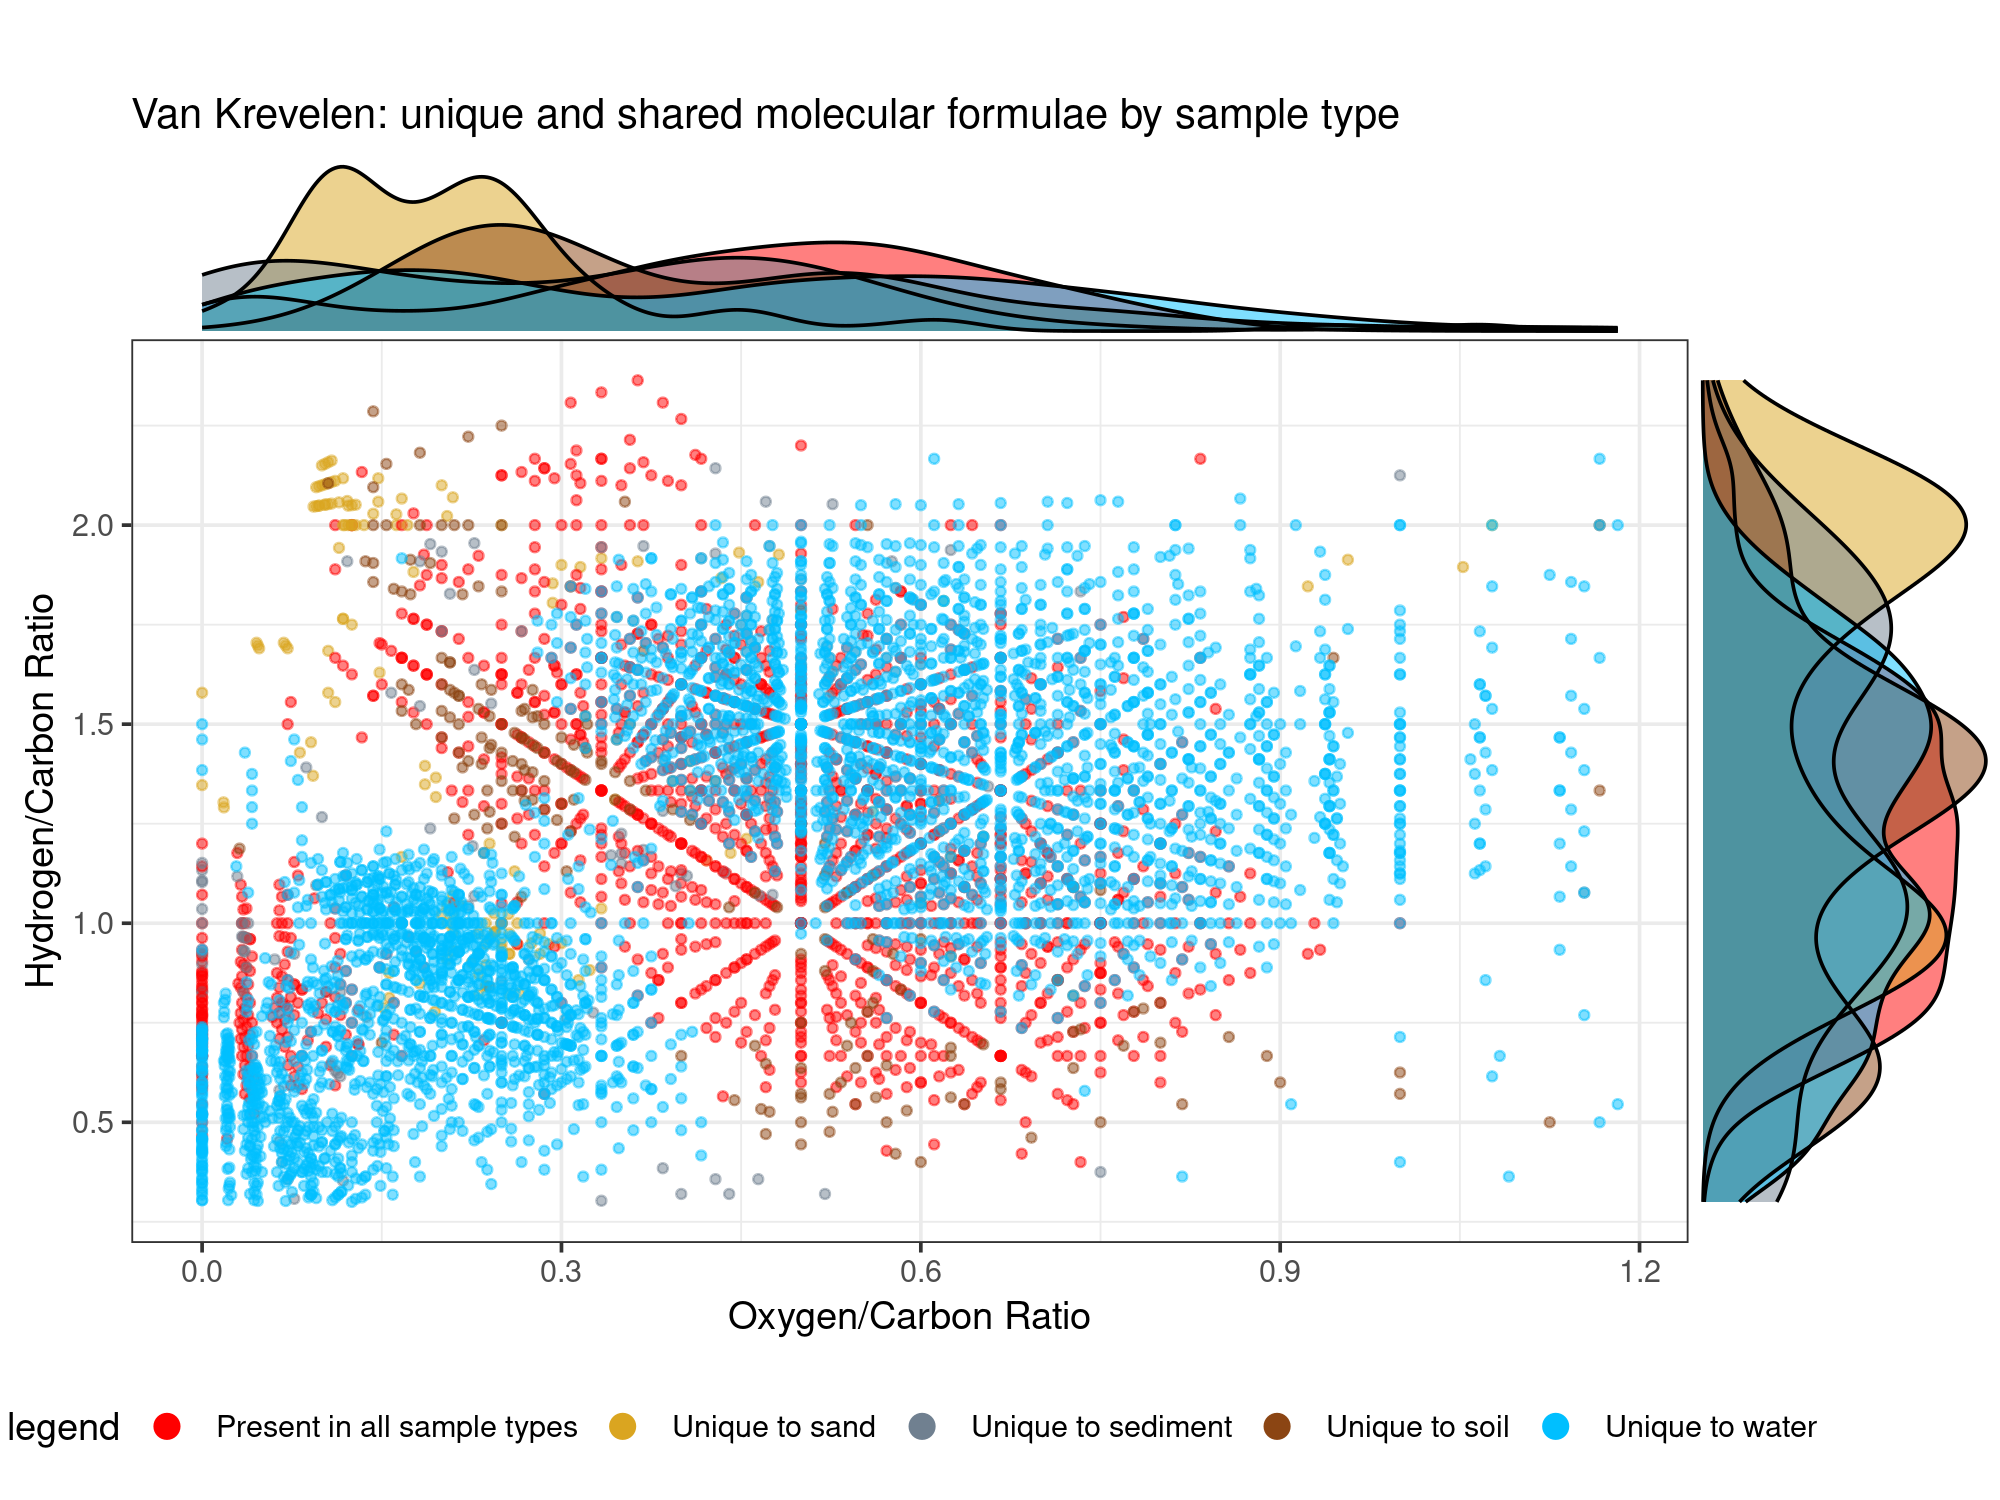

In [36]:
van_krevelen_shared_plot <- van_krevelen_data %>%
  mutate(exists = TRUE) %>%
  pivot_wider(names_from = bsm.sample_type_manual, values_from = exists) %>%
  mutate(across(where(is.logical), ~ !is.na(.x))) %>%
  
  # Label all shared formulae
  mutate(in_soil_only = soil & !sediment & !water & !sand,
         in_water_only = !soil & !sediment & water & !sand,
         in_sediment_only = !soil & sediment & !water & !sand,
         in_sand_only = !soil & !sediment & !water & sand,
         in_all_sample_types = sediment & soil & water) %>%
  
  # Back to long format for ggplot
  select(-soil, sediment, water, sand) %>%
  pivot_longer(cols = starts_with("in_"), 
               names_to = "sample_type", values_to  = "presence") %>%
  filter(presence) %>%
  
  # Make nicer labels for plot
  mutate(sample_type = case_when(
    sample_type == "in_soil_only" ~ "Unique to soil",
    sample_type == "in_water_only" ~ "Unique to water",
    sample_type == "in_sediment_only" ~ "Unique to sediment",
    sample_type == "in_sand_only" ~ "Unique to sand",
    sample_type == "in_all_sample_types" ~ "Present in all sample types"
  )) %>%
  
  # Construct scatterplot
  ggplot(aes(x = OC, y = HC, color = sample_type)) +
    geom_point(alpha = 0.5, size = 1) +
    theme_bw() +
    theme(legend.position = "bottom",
          plot.title = element_text(margin = margin(t = 1, unit = "cm"), size = 12)) +
    labs(title = "Van Krevelen: unique and shared molecular formulae by sample type",
         x = "Oxygen/Carbon Ratio", y = "Hydrogen/Carbon Ratio", color = "Sample Type") +
    guides(color = guide_legend(override.aes = list(alpha = 1, size = 3))) +
    scale_color_manual("legend", 
                       values = c("Unique to soil" = "saddlebrown", 
                                 "Unique to water" = "deepskyblue", 
                                 "Unique to sediment" = "slategray", 
                                 "Unique to sand" = "goldenrod",
                                 "Present in all sample types" = "red"))

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 250)

# Add marginal density plots
ggMarginal(van_krevelen_shared_plot, groupFill = TRUE)